# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [23]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline


### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [24]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [25]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(50))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): #  fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform()
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else: 
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    # Additional Feature, adding exclamation count
    toxic_data['exclam_count'] = toxic_data['comment_text'].str.count("!+")
    
    # Future work:
    # Investigating Regex for capitalization of words and string combinations
    # Look into possessiveness of language: "is a", "am a", "are a" as potential features  
  
    X_quant_features = toxic_data[["word_count", "punc_count", "exclam_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(50))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)

    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [26]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/toxiccomments_train.csv', my_random_seed=3378)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                  id                                       comment_text  \
0   0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1   000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2   000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3   0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4   0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
5   00025465d4725e87  "\n\nCongratulations from me as well, use the ...   
6   0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND

Shape of HashingVectorizer X:
(159571, 131072)
Look at a few rows of the new quantitative features: 
    word_count  punc_count  exclam_count
0           42           5             0
1           18           2             1
2           42           3             0
3          112           3             0
4           13           1             0
5           12           1             0
6            8           0             0
7           21           2             0
8           83           7             0
9           12           0             0
10         489          28             0
11          11           0             0
12          50          15             0
13         142           6             0
14          39           4             0
15         116           8             0
16          10           1             2
17           5           0             0
18          21           0             0
19          80           2             0
20          44           3            

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [27]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 6790, 'TN': 58517, 'FP': 56201, 'FN': 6148, 'Accuracy': 0.5115858244030833, 'Precision': 0.10779317680303535, 'Recall': 0.5248106353377647, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [28]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(shuffle=True)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12853, 'TN': 114630, 'FP': 88, 'FN': 85, 'Accuracy': 0.9986447953876042, 'Precision': 0.9931999072714628, 'Recall': 0.993430205595919, 'desc': 'svm_train'}


### MODEL: logistic regression

In [29]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12865, 'TN': 114665, 'FP': 53, 'FN': 73, 'Accuracy': 0.9990129723632262, 'Precision': 0.9958971977086236, 'Recall': 0.9943577059823775, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [30]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha = 0.01)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12701, 'TN': 103272, 'FP': 11446, 'FN': 237, 'Accuracy': 0.9084806041235821, 'Precision': 0.5259866650101462, 'Recall': 0.9816818673674448, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [31]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', penalty='l2', alpha= 0.0001)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12874, 'TN': 114637, 'FP': 81, 'FN': 64, 'Accuracy': 0.9988641348624429, 'Precision': 0.9937475878039367, 'Recall': 0.9950533312722214, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [32]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True, alpha=3)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12938, 'Neg': 114718, 'TP': 12858, 'TN': 101936, 'FP': 12782, 'FN': 80, 'Accuracy': 0.8992448455223413, 'Precision': 0.5014820592823713, 'Recall': 0.9938166640902767, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators = 1, bootstrap = True)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)



{'Pos': 12938, 'Neg': 114718, 'TP': 10323, 'TN': 112497, 'FP': 2221, 'FN': 2615, 'Accuracy': 0.9621169392742996, 'Precision': 0.8229432397959183, 'Recall': 0.7978822074509198, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

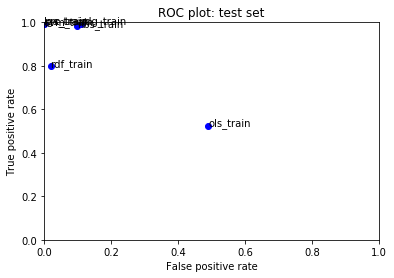

In [34]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [35]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [36]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
13
I HAVE A VANDAL BOT AND I AM WILLING TO USE IT IF I HAVE TO! I WILL BAN EVERYONE! 192.208.242.42
* * * * * * * * * 
294
i saw what you did and didn't realize the error i had made.  i reverted it back to yours.  Seems like u an Kww spend a lot of time together tag teaming other editors.  I think the date of sentencing is important because it is the last, but most important, step of the criminal justice process.  Plus, people will want to know this.  After he gets sentenced the language would of course need to be changed to the present tense and not the present future tense.  But the info itself about her being a crime victim and of what crime is relevant.  The fact that she is getting a large and disproportionate share of the restitution shows that she was the major victim here.  Pics of her with dildos all over the place are pretty explicit.
* * * * * * * * * 
420
Dan's not into Wrestling anymore 

I just thought maybe you guys would like to know that...

7905
Try Me 

I was gonna stop... just try me.
* * * * * * * * * 
7906
Hi, why did you delete the section about Shmuly being a convert? What was wrong with it? Thank you 184.177.112.118
* * * * * * * * * 
8179
"

One thing you should know about me
I really hate it when people use the word ""spam"" about me. My comment was just an information that i will save this article before it probably cease to exist. I handle so in german Wikipedia.
It has nothing to do with spam! I always use to save articles to Wikia projects when they're on deletion log. Keep that in mind and don't call that word anymore due to my presence   "
* * * * * * * * * 
8226
Go and tell Elonka to learn how to be an Admin!
* * * * * * * * * 
8464
Not sure why you feel as if you have ownership over this page. If you don't like it, it gets deleted, even if it archived fact? What's your problem?
* * * * * * * * * 
8647
warning
I read it. I'll consider it. I deleted it. Its my talk page, I'll do as I please with it. Quit be

19138
DestructoBot kills all images regardless of their tags!
* * * * * * * * * 
19253
"
I hope we can all agree that ""nor-FOLK"" is an abomination never uttered by anyone who lives anywhere in Southeastern VA.  Beyond that, I doubt there is a reliable source on local pronunciation.  After a brief search, the best I could find was this, which seems to support nor-FICK.  However, as a native to the area, NAW-fuhk is what I hear. '''' "
* * * * * * * * * 
19261
Gee spot, read this, why do you want to keep talking about black and white images from last century?
* * * * * * * * * 
19262
"
I suggest you keep a civil head, Doc- if you violate Wikipedia policy I certainly have the ""authority"" to block you; it's called being an admin. I'm sorry if I did not choose the correct diction for you, but yelling 'WTF' is not a way to endear yourself to other editors. Thank you. 

P.S., blocking that IP will ultimately do little, as the editor in question has a dynamic IP. Just so you know, he'll be

30386
You cal vandalism what is in reality putting your personal non-neutral POV into articles and not allowing free speech
Is there any authority to complain to about some uneducated student altering valid corrections to Wikis by people who reall kow something??
* * * * * * * * * 
30835
user:Binksternet That is the source from the book, I've got it sitting right next to me on page 122 where it calls it that 86.131.167.114
* * * * * * * * * 
30848
That just woke up? Come on wake up, slept too. 2.94.229.157
* * * * * * * * * 
31075
"Speedy deleting an article AFTER it's been fixed???==
Because it's ""better to nuke it and start from scratch""?  Utter lunacy.  No wonder editors are leaving Wikipedia...    

=="
* * * * * * * * * 
31160
April Fool's? 

hahaha
* * * * * * * * * 
31208
"

What are you talking about now?  What is a ""pool""?   "
* * * * * * * * * 
31486
" —Preceding unsigned comment added by 70.106.195.132   "
* * * * * * * * * 
31636
8. Wikipedia is not about the spread of 

42002
"

Yeah, you go ahead girlfriend Feudalist  "
* * * * * * * * * 
42133
central texas
i dont think so.74.192.12.135
* * * * * * * * * 
42833
Finally stop your edit wars and your crusade! If there is censorship, then it is done by you as you removed correct information.
* * * * * * * * * 
43152
You mean spices makes things taste different?  Surely, you jest.  The same thing happens when I look at Asians.  I tend to ignore the spices (their culture).  Black hair, brown eyes?  Rook rike Chinese to me!  Of course the most hilarious discussion was the one from Mr. Amateur Chef and Connoisseur who tried to brag about his credentials but was shown his taste buds were lacking.
* * * * * * * * * 
43325
(there are other criticisms)
* * * * * * * * * 
43334
"
(e/c x 11) hey yous this is a really easy question but where is the complement in this sentence, The man read a long book and then went to his cozy bed but before he did that he jumped into his pajamas first!! ǀ T ♦ C ♦  "
* * * * * * *

48783
":Tell you what: find me ONE use of this OUTSIDE of a web site (sex-lexis? You're kidding) and i'll drop my opposition to it. Just one magazine article. One book. One newspaper article. (Nandesuka)
Nandesuka, you gotta be shitting me - you aren't seriously asking us to find an unverifiable source for the term in favor of verifiable ones? (its, uh, mentioned in ""Dick and Jane get sexually mutilated"") Also, books and magazines kinda miss that handy ""search plaintext"" function.  

"
* * * * * * * * * 
48788
PS you have constantly failed to be respectful to me, youve been threating and upperty.
* * * * * * * * * 
49153
"

Well I'm stopping after the warning, don't block me, I guess I was in a dickish mood.►'''''' "
* * * * * * * * * 
49359
"
And then there all all those weasels ripping my flesh.  Rzz!  Rzz!  —Preceding unsigned comment added by 71.212.10.108   "
* * * * * * * * * 
49372
" (you should get a real job first, there is no way I'd ever ask for my so called ""priviledge

55842
I have no problem with you informing me because I know it is not me, you may as well ban this IP because the person below should stop coming to wikipedia if he has a problem with this.
* * * * * * * * * 
55894
if you want to sy something say it to my page.
* * * * * * * * * 
56191
ashley-ann want to become adentist
* * * * * * * * * 
56247
well terrilja , thats what u get , if you erase someones edit without proper reason , just because you have power to do so.  

I knoe you, terrilja , rschen and your admin friends are racist fellows who think that only british view is the correct view
* * * * * * * * * 
56850
Proud native white boy  

yea you need to get them in to this i would be down to chat it up with eathen and macey idk about cole tho cuz i dont really kno him so well ttyl kracker
* * * * * * * * * 
57036
I don't care. The whole concept of A inserts, B comes along and amends, C comes along and amends, is absurd. It works when it works. It doesn't work when it doesn't work.

69381
I'm very sorry to hear about your loss, Sandy.  Your companion at least had the solace of being your friend for so long.
* * * * * * * * * 
69459
Oh, are you one of this rogue admin's little apologist crew?  If so, please express yourself in terms to which I can respond.  If not, go back to giving him comfort for misusing his tools and acting like an overblown prefect.  His number's up.
* * * * * * * * * 
69905
":::First and foremost there is not and never has been any ""Wikistalking."" This is paranoia on Chadbryant's part and has been present in numerous remarks he has made, not just those dealing with reverting. I do find it humorous, however, that he has to claim ""Wikistalking"" yet he has a history of reverting an article in an edit war but trying to claim he is in no violation of a 3RR rule as a result of his changing non-existant ""vandalism.""

Second of all, I did not attack his talk page. You may go and see the history of the page if you wish to verify this, but all I 

75290
"

 Im leaving wiki 

oh wellGold Dragon "
* * * * * * * * * 
75350
OK ill respect your decision, i dont like or understand it but i wont complain anymore.
* * * * * * * * * 
75924
Re your comment, I was not concerned that women were concerned about the size of THEIR penises, but rather the size of their partners. I don't think this is an outrageous comment. Perhaps it was ambiguously worded.  02:25, 14 Jan 2004 (UTC)
* * * * * * * * * 
75927
Who do you think you are.
* * * * * * * * * 
76010
Stopped being funny? 

It never stops being funny.  It's even funnier now because it pisses you off ) Have a nice day!
* * * * * * * * * 
76265
Now you attempt to deny data. Data given by a global luminary. I think it is obvious to everyone else where the true bias lies. With you and your self-serving rewrites. You are just trying to stroke your tiny ego. I ask you to please take your abusive behavior somewhere else. I have reported you.
* * * * * * * * * 
76325
"

 Londonderry 

Hi, Are you

82482
FOR THE LOVE OF GOD KEEP IT!!! 

you have an article about mr hands, you have an article about freaking camel toes. Yet you are going to delete which my quite possibly be the best thing to ever happen on the internet?  For the love of god man, keep this article, it's only going to get better!
* * * * * * * * * 
82663
"

Because 3 people does not want it in the article.  Sucks alot because the Melungeon page is now filled with what those 3 people want and the unbiased people who does not run websites that goes against the actual historical records are the only ones being allowed to edit.  They are not having to show their edits as being reliable...and if anyone speaks up about it they tell one of their admins friends to come ban the unbiased people.  The host of one of the history channels ""America unearthed"" has already spoke out about those people also.  Even if we get our edits approved by Admins..those 3 people will still remove it.   It is a endless circle."
* * * * * * * *

93683
"See my note in the afd regarding Eduard Einstein.  I didn't say the article was too short, I said it's not noteworthy.  If you can convince me he's noteworthy, I'll be happy to withdraw.  But we don't include relatives of famous people and we don't include schizophrenics — why would we include a relative of a famous person who happened to have schizophrenia?  —  
Please stick to the facts. Speculation about people under 30, snide comments about my edits, etc., don't help determine the merit of the Eduard Einstein article. BTW - if you don't like my edits - this is Wikipedia - you can improve them as you see fit. My writing skill has no bearing on EE's noteworthiness.  
I didn't begin the speculation about Paris Hilton and her dumb dog.  It also wasn't me that claimed that the article was too short or that said that Eduard Einstein - whom I'd never even heard of before this - is more notable than Paris Hilton - who I'd heard of long before she even started getting on TV and movie

100029
to use on Aaron Christianson because he is gay
* * * * * * * * * 
100214
Are you a paid PR & small time editor of these fake women LOL who potray false info on Wikipedia misleading people! Going by your name you sound japanese! So what do you know about lakshmi manchu? She was born in Modugulapalem in chittoor on October-8th-1970 married twice! Just go research your facts first and make an effort to publish some true facts instead of deleting the truth. How pitiful! Also it is not allowed to hVd wiki pages without DOB so go find your facts first Yamaguchi or whoever u are!
* * * * * * * * * 
100267
pps - has anyone questioned why this is a starter page?  I have and when someone helps out by adding content they are discouraged. sham sham on all you who stand behing Blotto adrift and dont follow wikipedia guidelines.  tis tis
* * * * * * * * * 
100296
PS: the battle over your userpage disparagement has made the Wikipedia Review. Congratulations.
* * * * * * * * * 
100633
Congrats!

111681
im tired. should i go to bed?
* * * * * * * * * 
112014
If you're that ignorant I'll just remove it in it's entirety.
* * * * * * * * * 
112218
As I told you, that's just a POV, that directly sends a message of separatism and hatred. That's what is isolating you and your 'supporters' from the real world and makes you being BALKAn instead of EU. It will be like that until you accept the reality and face the truth, which is the facts I that I listed above. Adios
* * * * * * * * * 
112228
@ and @ What you say to it?
* * * * * * * * * 
112401
Yo - Don't be vandalizing pages.
* * * * * * * * * 
112802
Remove you edits vandal
* * * * * * * * * 
112887
"

 You Bloceked Me Therefore I AM Drunk And You Will Pay, You Refused To Unblock Me And My Friedn And I Warned Retribution So Here It Is On Your Very Own Page, You Racist 

Craig ""Brown"" Mcewan
Craig ""Brown"" Mcewan Born In The Year Of 1991, The Year Of The Brown? I Think So, Born In Browtown USA He Is Widely Regarded As The One Man 

117373
I think all of this belongs to Nong Han Kumphawapi Lake.
* * * * * * * * * 
117571
I dropped by here just to say 
Good Job, You lived your life well.
I enjoyed the one article you wrote here.
Godspeed. 71.154.148.149
* * * * * * * * * 
117608
Once more I am sorry you take life far too seriously. I truly feel sorry for you and wish you didn't carry such venom for those you don't know personally. Life is too short for such hatred and the matter isn't so much an argument as it is you attempting to make yourself feel better at my expense. If this is what makes you happy with your life I will not object. If you need a friend I'm there for you, no questions asked. I've helped people with issues such yourself quite a bit in my life and know how you feel.   )
* * * * * * * * * 
118280
Why don't you leave my page alone? Do I try to destroy YOUR work?????
* * * * * * * * * 
118398
Hey,

I'll get back to you later today  -I'm about to go to work,

Thanks,

Philip
* * * * * * * * * 
118991


124595
What's the deal with SineBot anywho? I don't get the big deal about signing....
* * * * * * * * * 
124755
serriosly 

What is going on?
* * * * * * * * * 
125122
Are you a furry? 

I think you're a furry.

confirm/deny
* * * * * * * * * 
125157
"
Oppose per my comments above. The song is the most likely outcome when searched for. '''''' Dick Laurent is dead "
* * * * * * * * * 
125309
"I've noticed that a lot of Wiki admins are rude and aggressive towards contributors who do not have ""admin status"" on Wikipedia. So here's a rant backed up by reliable ... 
"
* * * * * * * * * 
125666
You won this for being rude to other contributers by the way.
* * * * * * * * * 
125743
Mulatto as applied to a person in the present day is taken as a racist insult, not much better than calling someone a nigger.  This is not a negotiable issue; a gallery of living people will not be used in an article about a racist term.
* * * * * * * * * 
125867
, pompous and abusing the little authority I have

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [37]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 1742, 'TN': 14606, 'FP': 14022, 'FN': 1545, 'Accuracy': 0.512235625881247, 'Precision': 0.1105049479827455, 'Recall': 0.5299665348341953, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [38]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 2088, 'TN': 27129, 'FP': 1499, 'FN': 1199, 'Accuracy': 0.9154629484568385, 'Precision': 0.582102035126847, 'Recall': 0.6352296927289321, 'desc': 'svm_test'}


### MODEL: logistic regression

In [39]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 2044, 'TN': 27127, 'FP': 1501, 'FN': 1243, 'Accuracy': 0.9140216199279336, 'Precision': 0.5765867418899859, 'Recall': 0.6218436264070581, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [40]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 1987, 'TN': 24330, 'FP': 4298, 'FN': 1300, 'Accuracy': 0.8245965846780511, 'Precision': 0.3161495624502784, 'Recall': 0.6045025859446304, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [41]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 2076, 'TN': 27177, 'FP': 1451, 'FN': 1211, 'Accuracy': 0.916590944696851, 'Precision': 0.5886022115111993, 'Recall': 0.631578947368421, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [42]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 3108, 'TN': 23863, 'FP': 4765, 'FN': 179, 'Accuracy': 0.8450885163716121, 'Precision': 0.3947669249333164, 'Recall': 0.945543048372376, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [43]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3287, 'Neg': 28628, 'TP': 1500, 'TN': 27171, 'FP': 1457, 'FN': 1787, 'Accuracy': 0.898355005483315, 'Precision': 0.5072708826513358, 'Recall': 0.456343170063888, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

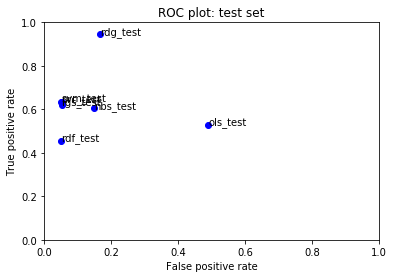

In [44]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [46]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/toxiccomments_test.csv', my_random_seed=3378, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                  id                                       comment_text
0   00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1   0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2   00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3   00017563c3f7919a  :If you have a look back at the source, the in...
4   00017695ad8997eb          I don't anonymously edit articles at all.
5   0001ea8717f6de06  Thank you for understanding. I think very high...
6   00024115d4cbde0f  Please do not add nonsense to Wikipedia. Such ...
7   000247e83dcc1211                   :Dear god this site is horrible.
8   00025358d4737918  " \n Only a fool can believe in such numbers. ...
9   00026d1092fe71cc  == Double Red

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [47]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.37786947324436554


In [48]:
raw_data.head()

,id,comment_text,word_count,punc_count,exclam_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [49]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [50]:
my_submission.shape

(153164, 2)

In [51]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/final_assignment_1/Submissions/toxiccomments_submission_final.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation